In [4]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from rasterio.features import geometry_mask
from skimage.segmentation import slic
from skimage.measure import regionprops
from shapely.geometry import Point


In [5]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus images with existing images
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {walrus_path}")
            continue

        matching_images = [image for image in image_paths if island in image and date in image]
        if not matching_images:
            print(f"No matching image found for {walrus_path}")
            continue

        image_path = matching_images[0]
        file_pairs[image_path] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to segment image and extract object features
def segment_and_extract_features(image_path, shapefile_path, n_segments=1000):
    with rasterio.open(image_path) as src:
        image = src.read().transpose(1, 2, 0)
        transform = src.transform

    # Perform SLIC segmentation
    segments = slic(image, n_segments=n_segments, compactness=10, sigma=1)

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for region in regionprops(segments):
        mask = region.image
        object_pixels = image[region.coords[:, 0], region.coords[:, 1], :]
        
        # Calculate object features (mean and std for each band)
        object_features = np.concatenate([
            np.mean(object_pixels, axis=0),
            np.std(object_pixels, axis=0)
        ])

        # Get centroid of the region
        centroid = region.centroid
        point = Point(transform * (centroid[1], centroid[0]))  # Convert to georeferenced point

        # Find the label of the polygon that contains this point
        containing_polygons = gdf[gdf.geometry.contains(point)]
        if len(containing_polygons) > 0:
            label = containing_polygons.iloc[0]['label']
        else:
            label = 'unknown'

        features.append(object_features)
        labels.append(label)
        img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Function to get dataset
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        obj_features, obj_labels, obj_name = segment_and_extract_features(image_path, shapefile_path)
        features.append(obj_features)
        labels.append(obj_labels)
        image_name.append(obj_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

# Extract features and labels
features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame(features, columns=[f'feature_{i}' for i in range(features.shape[1])])
dataset['labels'] = labels
dataset['encoded_labels'] = encoded_labels
dataset['image_name'] = image_name

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [6]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in le.transform(['walrus_pure', 'walrus_mixed'])):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")

# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



Training Class Distribution:
unknown: 12500
ocean: 2106
ice: 843
rock: 445
freshwater: 79
walrus_mixed: 9
walrus_pure: 3

Test Class Distribution:
unknown: 3126
ocean: 527
ice: 210
rock: 112
freshwater: 20
walrus_mixed: 2

Test Dataset Island Distribution:
tor: 1584
buch: 1200
pal: 575
sars: 415
moff: 223

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 186
Image: buch_20230720_image.tif, Pixels: 208
Image: buch_20230731_image.tif, Pixels: 189
Image: buch_20230923_image.tif, Pixels: 179
Image: moff_20230717_image.tif, Pixels: 223
Image: pal_20230714_image.tif, Pixels: 204
Image: pal_20230720_image.tif, Pixels: 184
Image: pal_20230726_image.tif, Pixels: 187
Image: sars_20230714_image.tif, Pixels: 197
Image: sars_20230803_image.tif, Pixels: 218
Image: tor_20230801_image.tif, Pixels: 228
Image: tor_20230824_image.tif, Pixels: 196
Image: tor_20230901_image.tif, Pixels: 218
Image: tor_20230902_image.tif, Pixels: 219
Image: buch_20230825_image.tif, Pixels:

In [7]:
# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [8]:
# Evaluate the Random Forest model
y_pred = rf.predict(X_test)

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print Metrics
print("Random Forest Model")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Model
Accuracy: 0.8621466099574681
Precision: 0.8549257008161656
Recall: 0.8621466099574681
F1 Score: 0.8543463010598905
Cohen's Kappa: 0.5879295092530987

Classification Report:


ValueError: Number of classes, 6, does not match size of target_names, 7. Try specifying the labels parameter

Labels present in buch_20230825_image.tif: ['unknown']


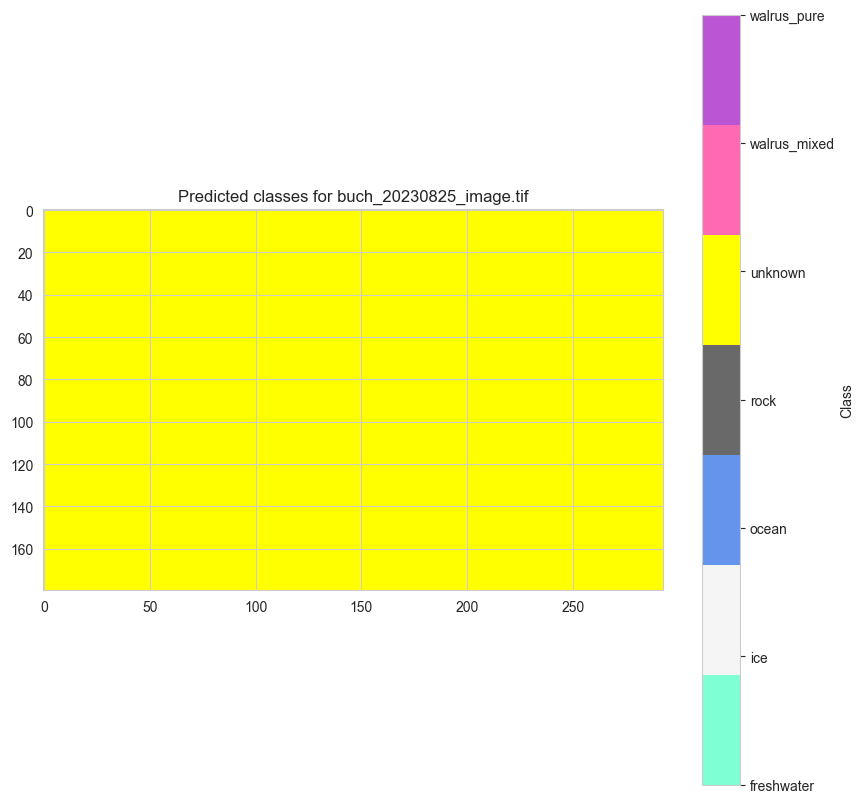

Labels present in buch_20230901_image.tif: ['ice', 'unknown']


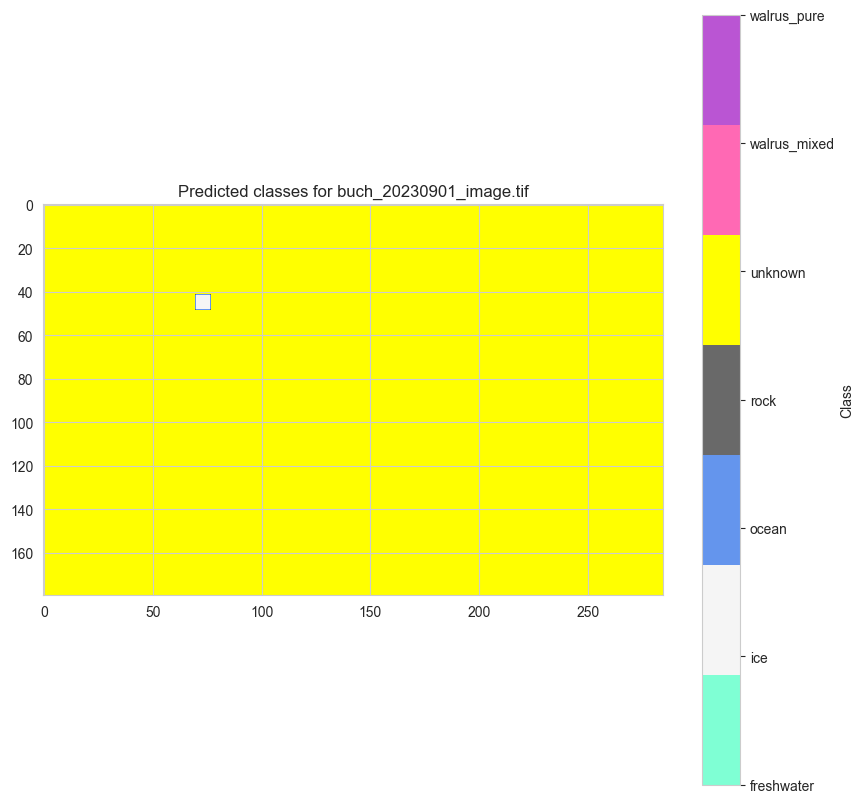

Labels present in pal_20230817_image.tif: ['ocean', 'rock', 'unknown']


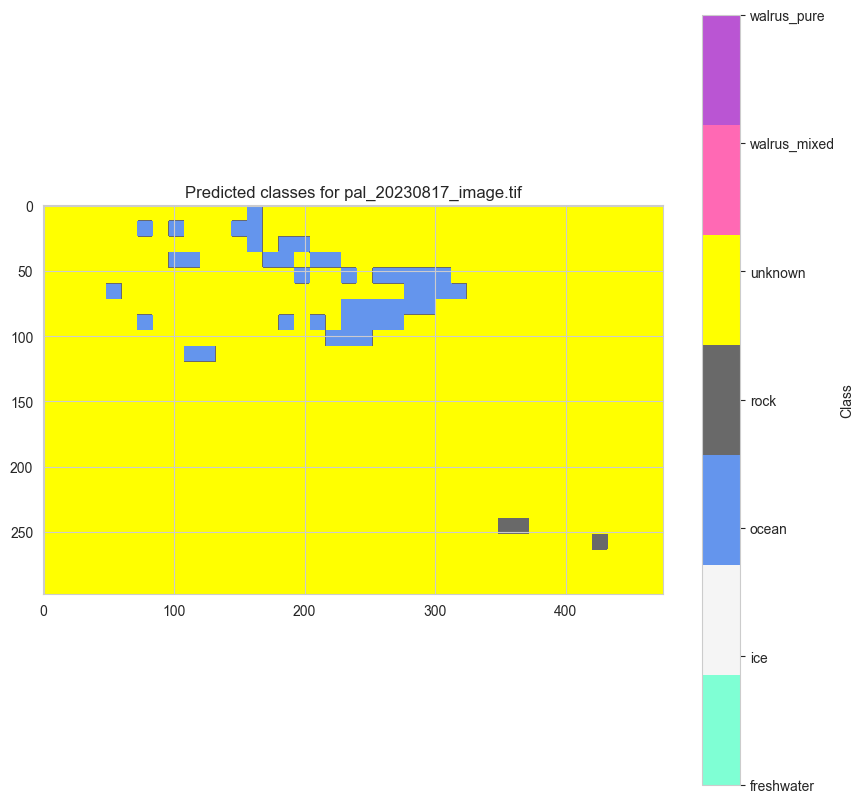

Labels present in pal_20230901_image.tif: ['ice', 'rock', 'unknown']


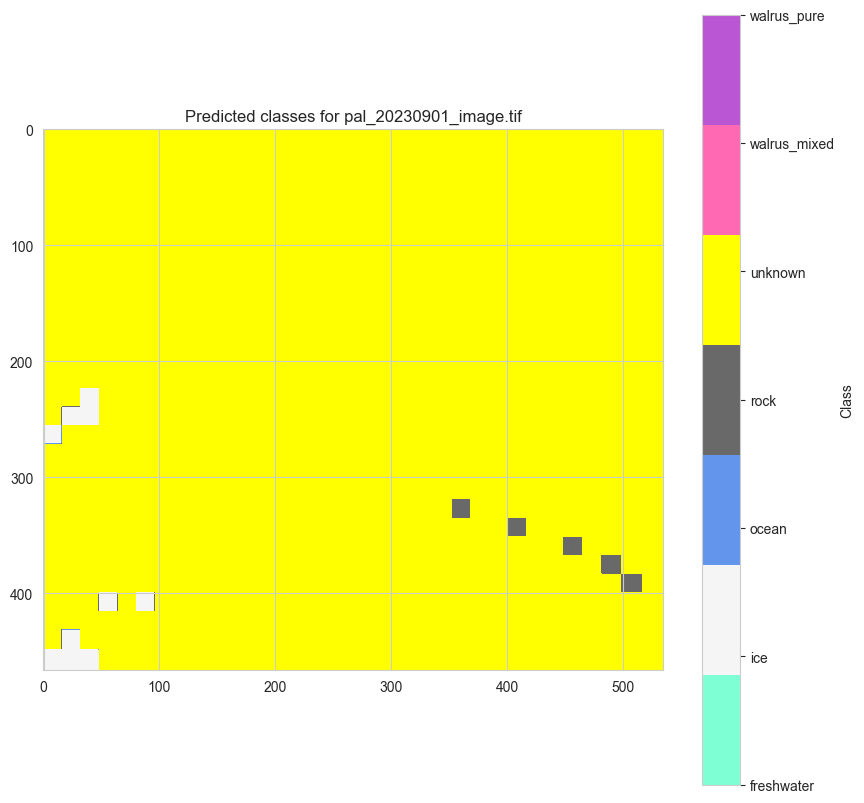

Labels present in pal_20230902_image.tif: ['unknown']


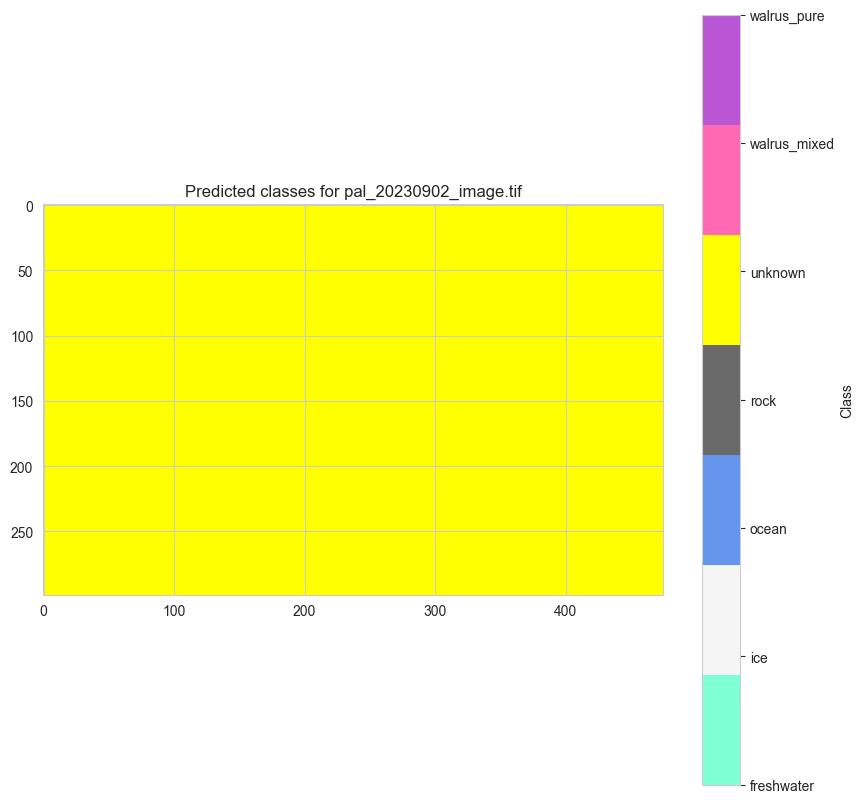

Labels present in pal_20230910_image.tif: ['ice', 'unknown']


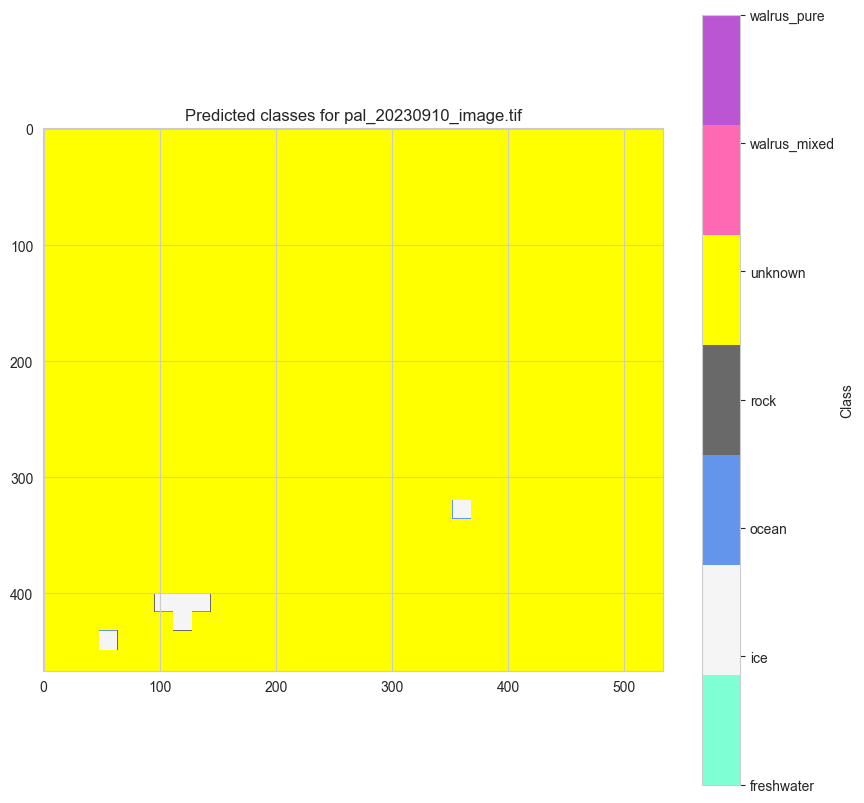

Labels present in pal_20230923_image.tif: ['ice', 'unknown']


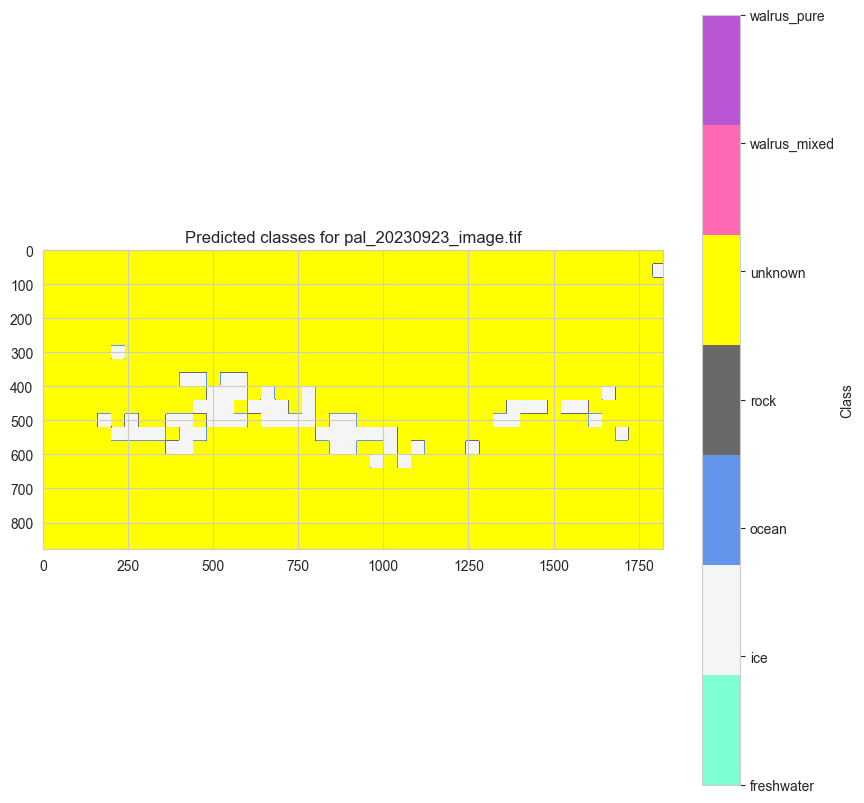

Labels present in sars_20230719_image.tif: ['unknown']


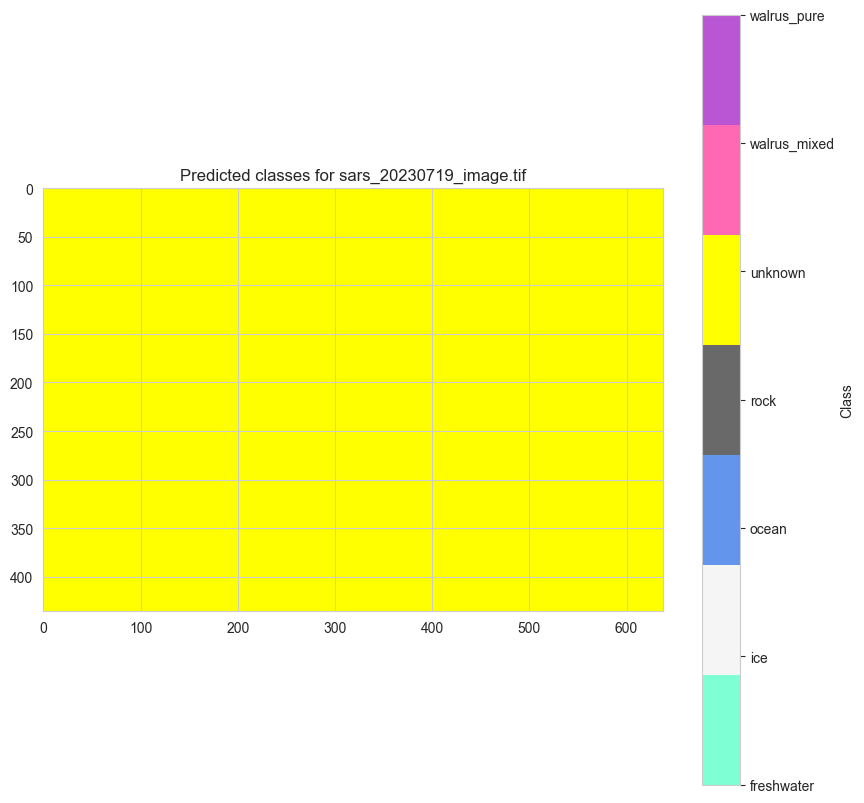

Labels present in sars_20230726_image.tif: ['ocean', 'unknown']


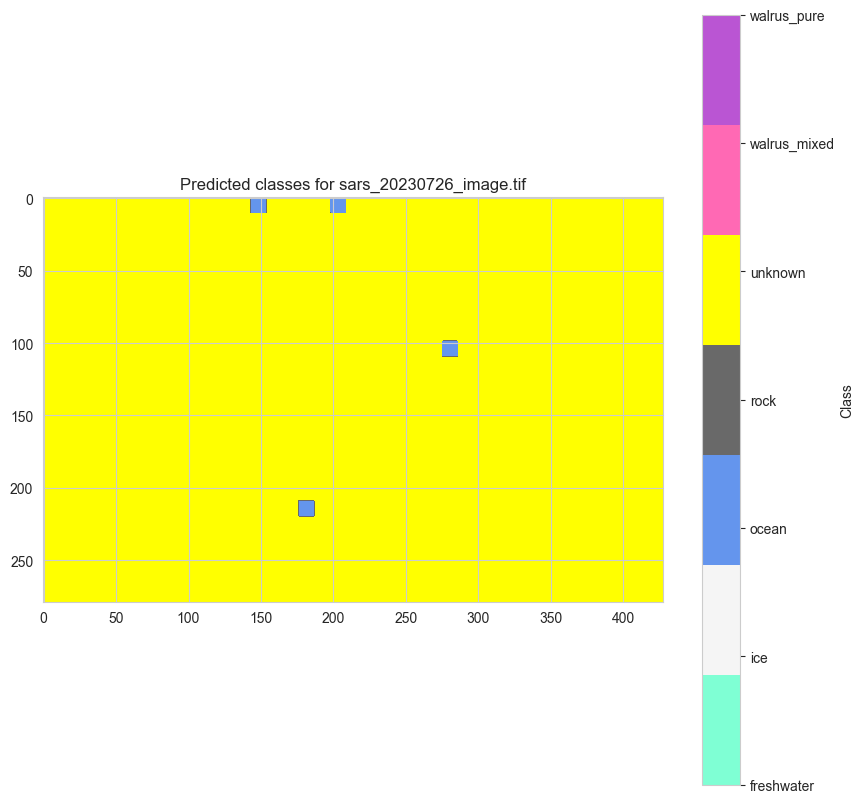

Labels present in sars_20230808_image.tif: ['ocean', 'unknown']


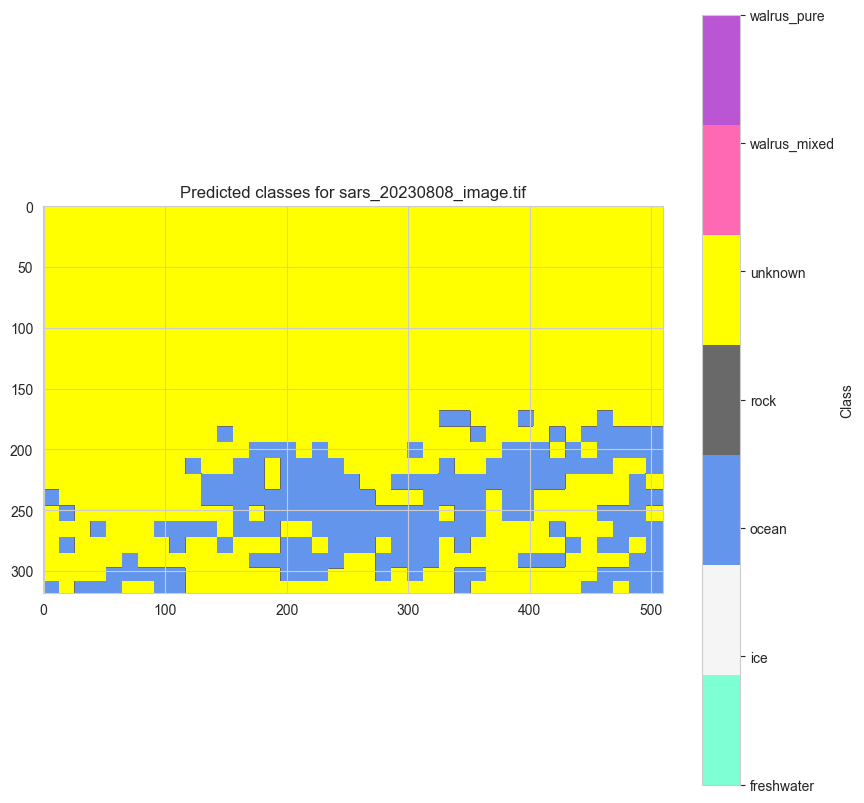

Labels present in tor_20230714_image.tif: ['unknown']


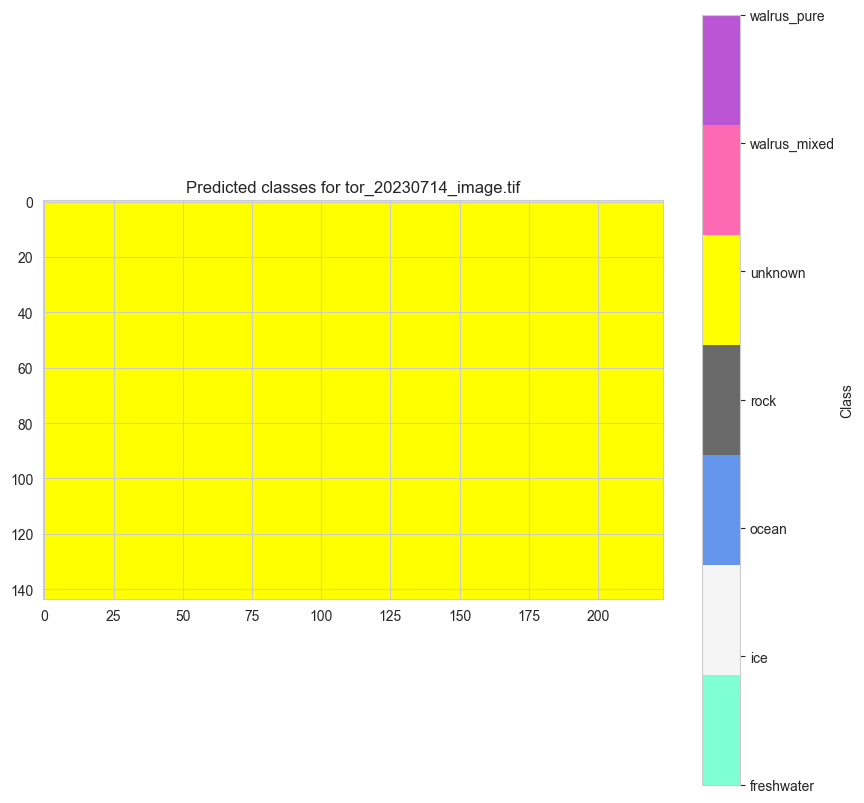

Labels present in tor_20230717_image.tif: ['unknown', 'walrus_mixed', 'walrus_pure']


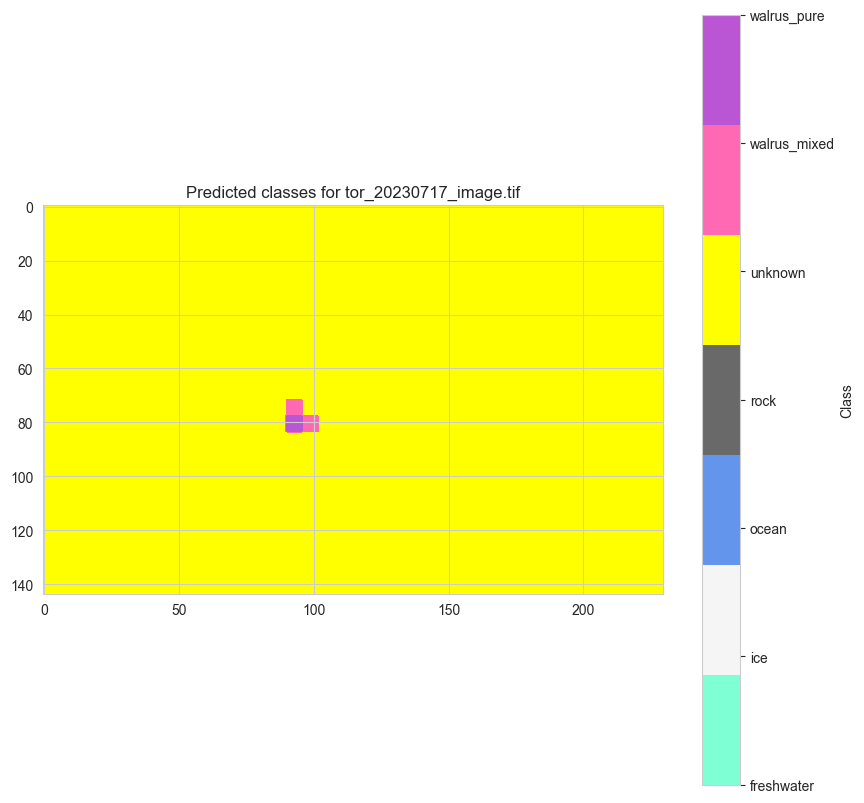

Labels present in tor_20230803_image.tif: ['unknown', 'walrus_mixed']


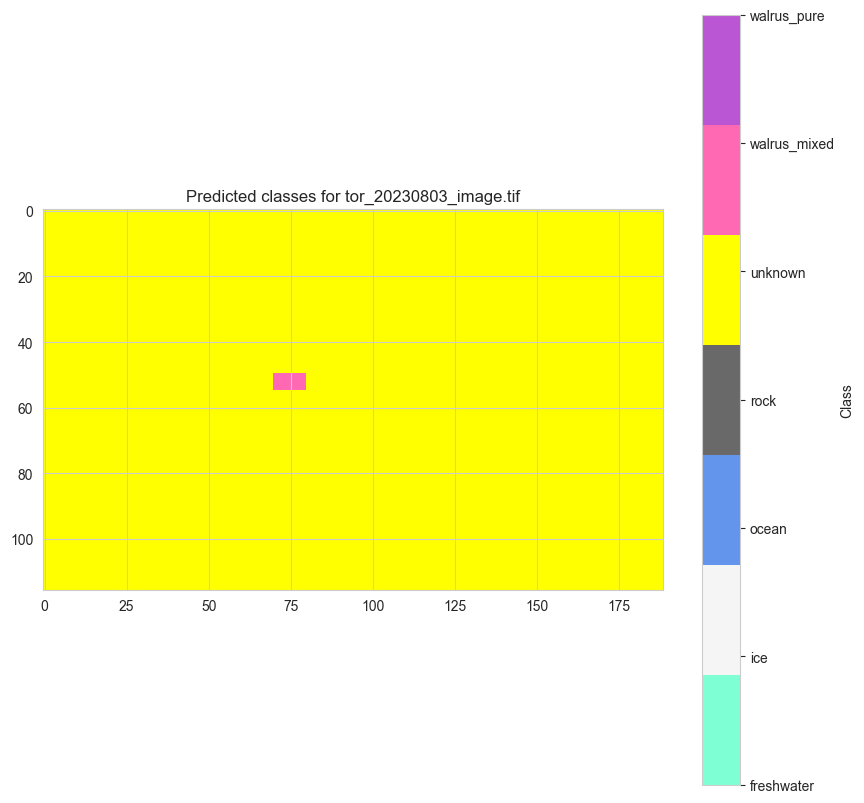

Labels present in tor_20230825_image.tif: ['unknown', 'walrus_mixed']


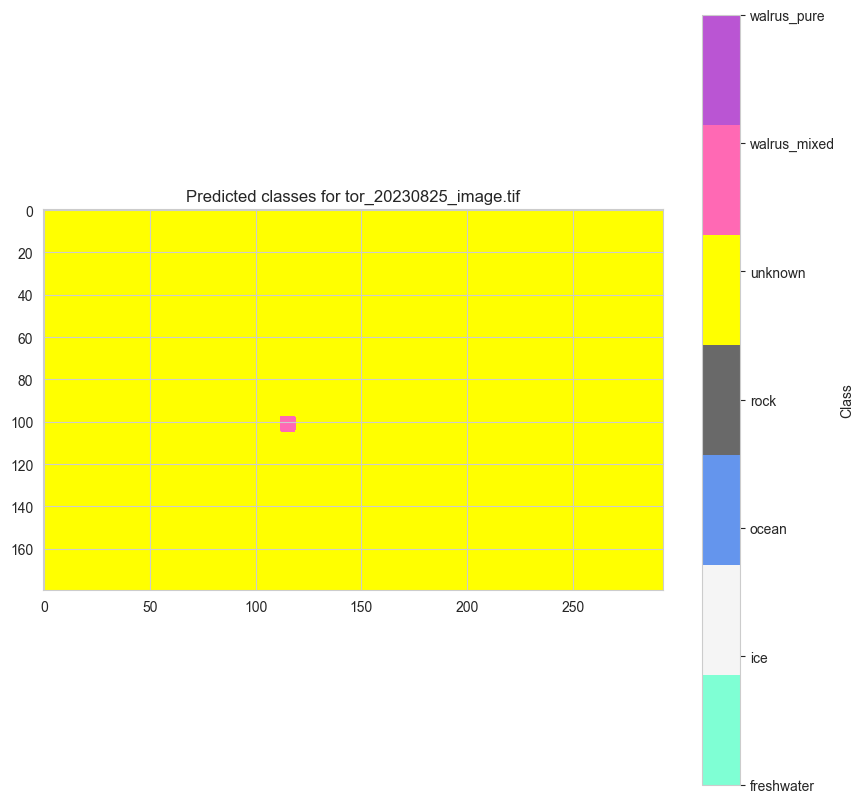

Labels present in tor_20230910_image.tif: ['ice', 'unknown']


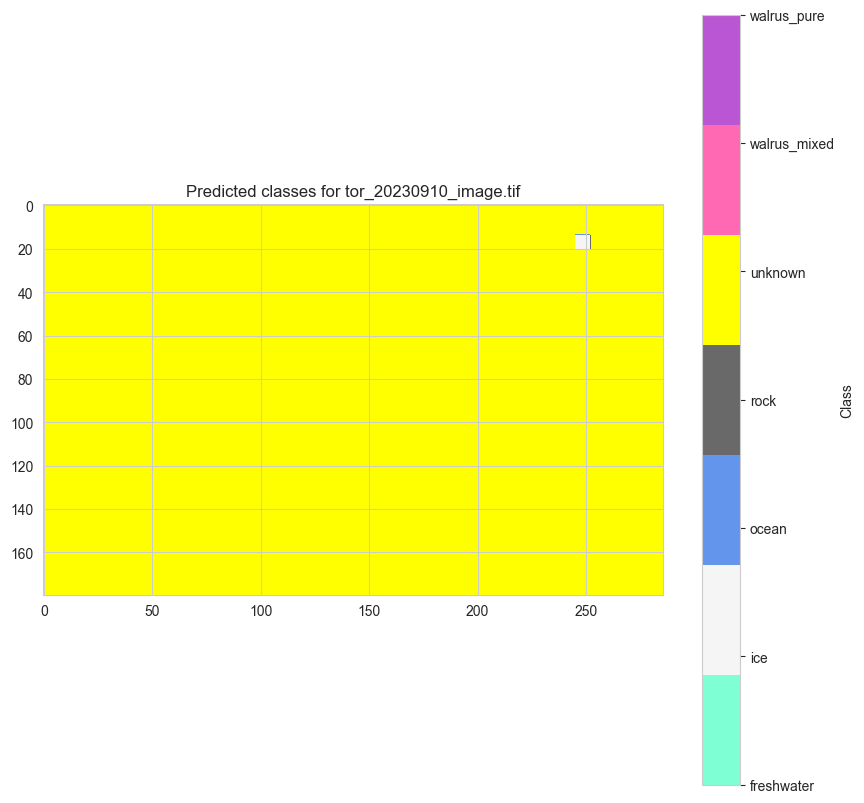

In [9]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read().transpose(1, 2, 0)
    
    segments = slic(image, n_segments=1000, compactness=10, sigma=1)
    
    object_features = []
    for region in regionprops(segments):
        object_pixels = image[region.coords[:, 0], region.coords[:, 1], :]
        object_features.append(np.concatenate([
            np.mean(object_pixels, axis=0),
            np.std(object_pixels, axis=0)
        ]))
    
    predictions = model.predict(object_features)
    
    predicted_image = np.zeros((image.shape[0], image.shape[1]), dtype=int)
    for region, prediction in zip(regionprops(segments), predictions):
        predicted_image[region.coords[:, 0], region.coords[:, 1]] = prediction
    
    return predicted_image

# Predict classes for unlabeled images
predicted_images = {}
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, rf)
    predicted_images[image_path] = predicted_image

# Define a color map for the labels
label_colors = {
    'freshwater': 'aquamarine',
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink',
    'unknown': 'yellow'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [17]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus images with existing images
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {walrus_path}")
            continue

        matching_images = [image for image in image_paths if island in image and date in image]
        if not matching_images:
            print(f"No matching image found for {walrus_path}")
            continue

        image_path = matching_images[0]
        file_pairs[image_path] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to segment image and extract object features
def segment_and_extract_features(image_path, shapefile_path, n_segments=10000):
    with rasterio.open(image_path) as src:
        image = src.read().transpose(1, 2, 0)
        transform = src.transform

    # Perform SLIC segmentation
    segments = slic(image, n_segments=n_segments, compactness=1, sigma=1)

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for region in regionprops(segments):
        mask = region.image
        object_pixels = image[region.coords[:, 0], region.coords[:, 1], :]
        
        # Calculate object features (mean and std for each band)
        object_features = np.concatenate([
            np.mean(object_pixels, axis=0),
            np.std(object_pixels, axis=0)
        ])

        # Get centroid of the region
        centroid = region.centroid
        point = Point(transform * (centroid[1], centroid[0]))  # Convert to georeferenced point

        # Find the label of the polygon that contains this point
        containing_polygons = gdf[gdf.geometry.contains(point)]
        if len(containing_polygons) > 0:
            label = containing_polygons.iloc[0]['label']
        else:
            label = 'unknown'

        features.append(object_features)
        labels.append(label)
        img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Function to get dataset
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        obj_features, obj_labels, obj_name = segment_and_extract_features(image_path, shapefile_path)
        features.append(obj_features)
        labels.append(obj_labels)
        image_name.append(obj_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

# Extract features and labels
features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame(features, columns=[f'feature_{i}' for i in range(features.shape[1])])
dataset['labels'] = labels
dataset['encoded_labels'] = encoded_labels
dataset['image_name'] = image_name

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [12]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in le.transform(['walrus_pure', 'walrus_mixed'])):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")

# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



Training Class Distribution:
unknown: 25967
ocean: 4313
ice: 1758
rock: 974
freshwater: 178
walrus_mixed: 16
walrus_pure: 2

Test Class Distribution:
unknown: 6492
ocean: 1078
ice: 440
rock: 243
freshwater: 44
walrus_mixed: 5
walrus_pure: 1

Test Dataset Island Distribution:
tor: 3414
buch: 2525
pal: 1216
sars: 770
moff: 378

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 420
Image: buch_20230720_image.tif, Pixels: 414
Image: buch_20230731_image.tif, Pixels: 454
Image: buch_20230923_image.tif, Pixels: 403
Image: moff_20230717_image.tif, Pixels: 378
Image: pal_20230714_image.tif, Pixels: 400
Image: pal_20230720_image.tif, Pixels: 410
Image: pal_20230726_image.tif, Pixels: 406
Image: sars_20230714_image.tif, Pixels: 366
Image: sars_20230803_image.tif, Pixels: 404
Image: tor_20230801_image.tif, Pixels: 453
Image: tor_20230824_image.tif, Pixels: 428
Image: tor_20230901_image.tif, Pixels: 385
Image: tor_20230902_image.tif, Pixels: 411
Image: buch_2023082

In [13]:
# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Random Forest Model
Accuracy: 0.8789594122606287
Precision: 0.8746497132486524
Recall: 0.8789594122606287
F1 Score: 0.8739274604039019
Cohen's Kappa: 0.6485560076977657

Classification Report:
              precision    recall  f1-score   support

  freshwater       1.00      0.34      0.51        44
         ice       0.79      0.53      0.63       440
       ocean       0.76      0.74      0.75      1078
        rock       0.72      0.55      0.62       243
     unknown       0.91      0.94      0.92      6492
walrus_mixed       0.00      0.00      0.00         5
 walrus_pure       0.00      0.00      0.00         1

    accuracy                           0.88      8303
   macro avg       0.59      0.44      0.49      8303
weighted avg       0.87      0.88      0.87      8303


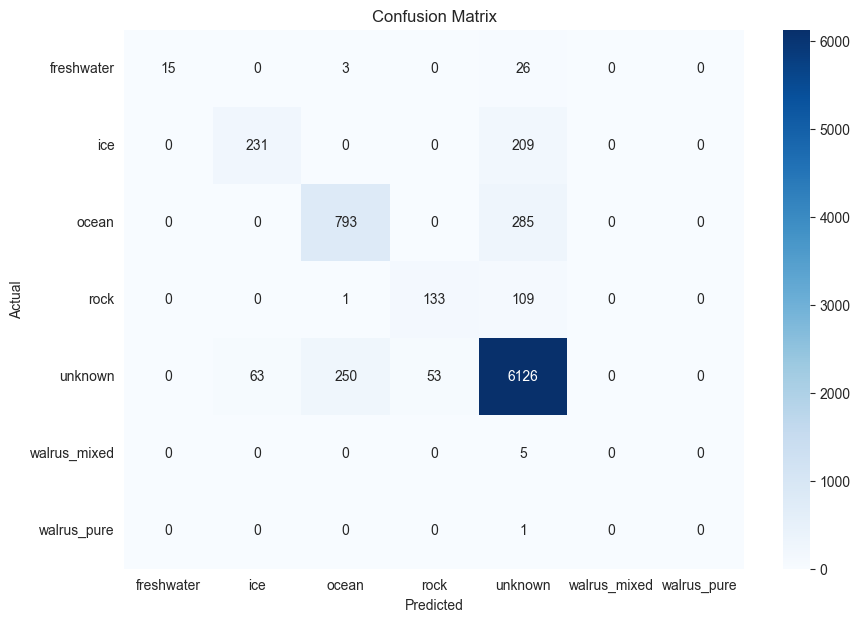

In [18]:
# Evaluate the Random Forest model
y_pred = rf.predict(X_test)

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print Metrics
print("Random Forest Model")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Labels present in buch_20230825_image.tif: ['ice', 'rock', 'unknown']


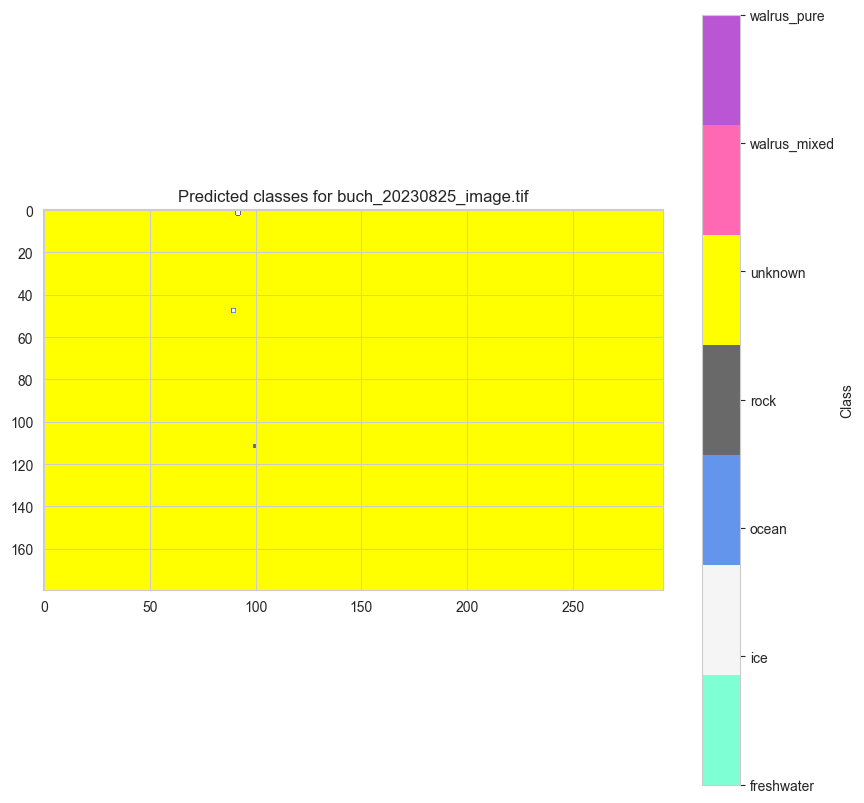

Labels present in buch_20230901_image.tif: ['unknown']


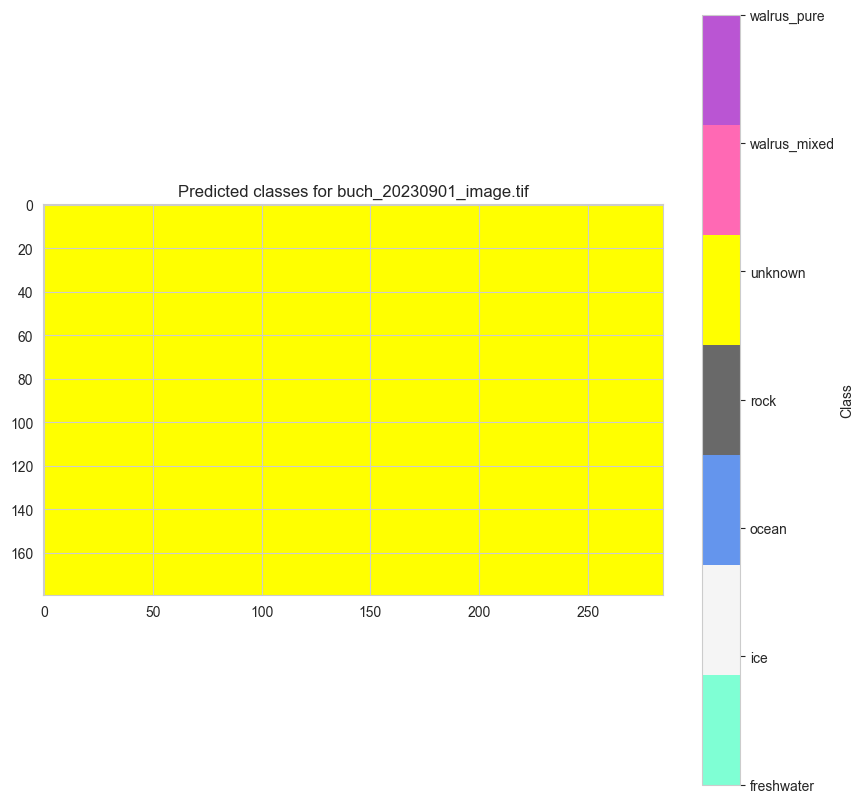

Labels present in pal_20230817_image.tif: ['ice', 'ocean', 'unknown']


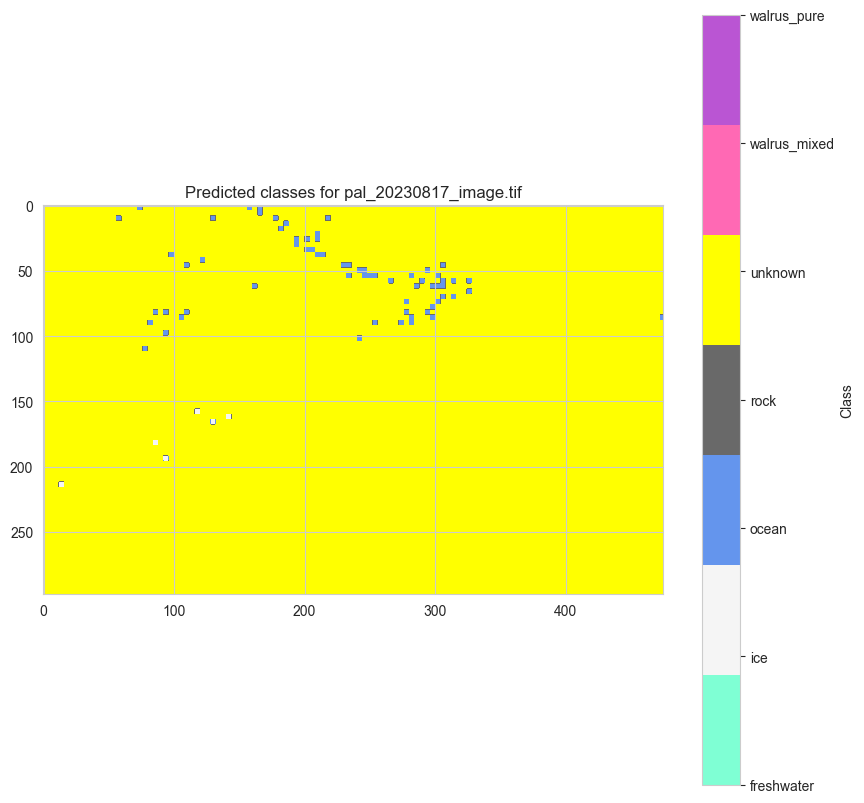

Labels present in pal_20230901_image.tif: ['ice', 'ocean', 'unknown']


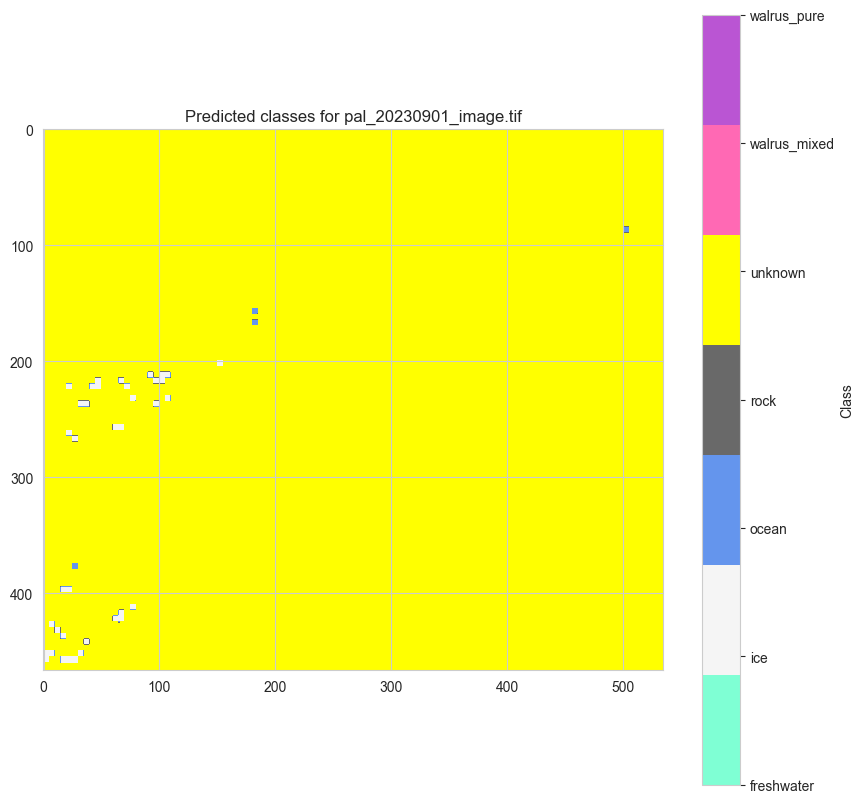

Labels present in pal_20230902_image.tif: ['ocean', 'rock', 'unknown']


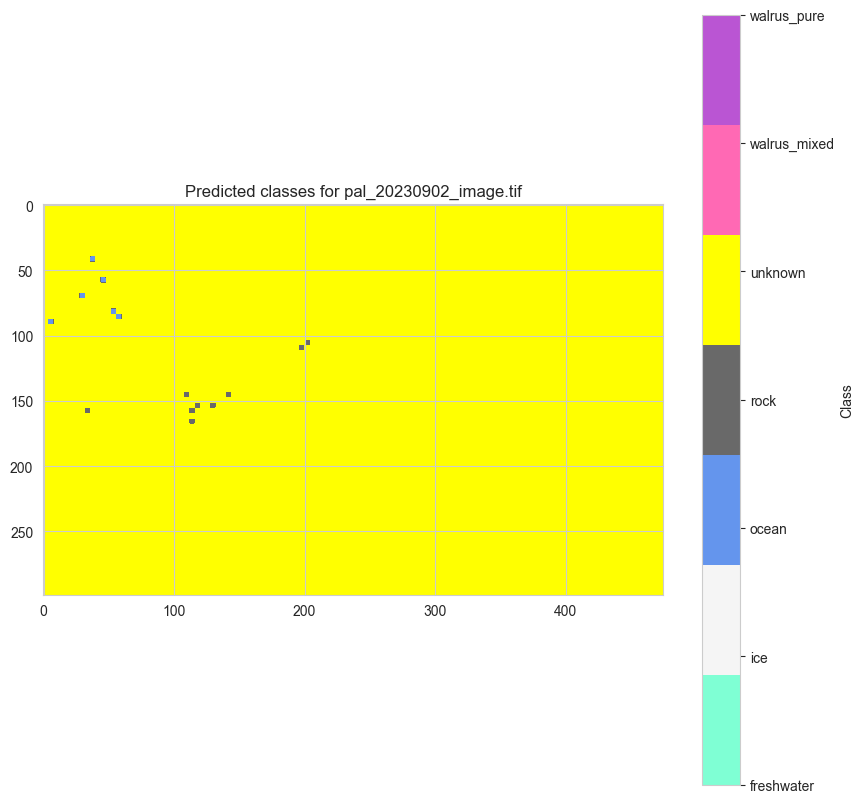

Labels present in pal_20230910_image.tif: ['ice', 'ocean', 'unknown']


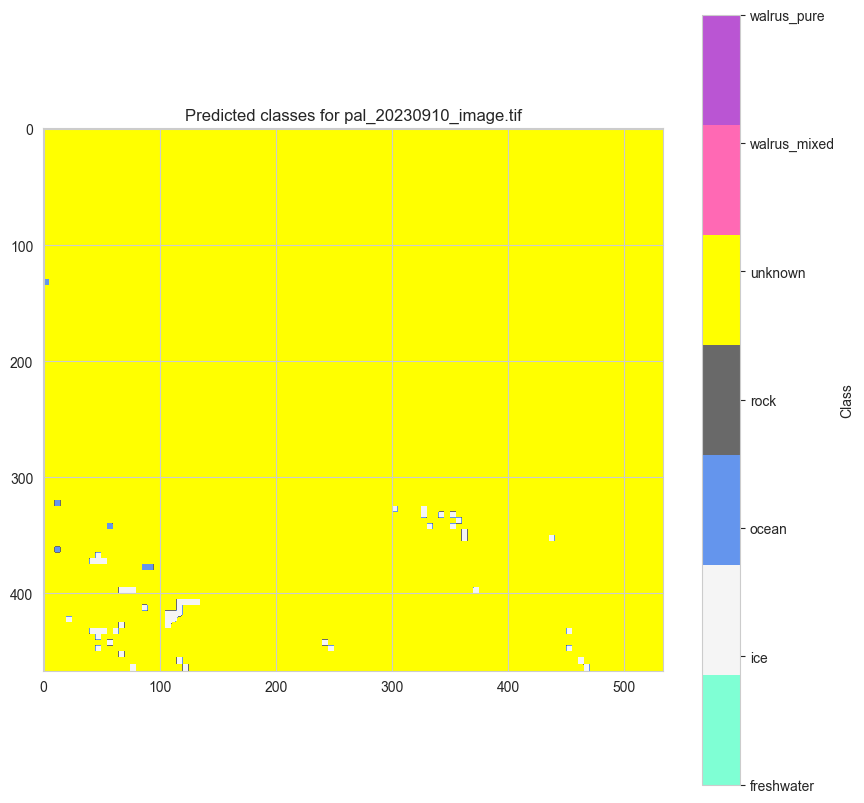

Labels present in pal_20230923_image.tif: ['freshwater', 'ice', 'rock', 'unknown']


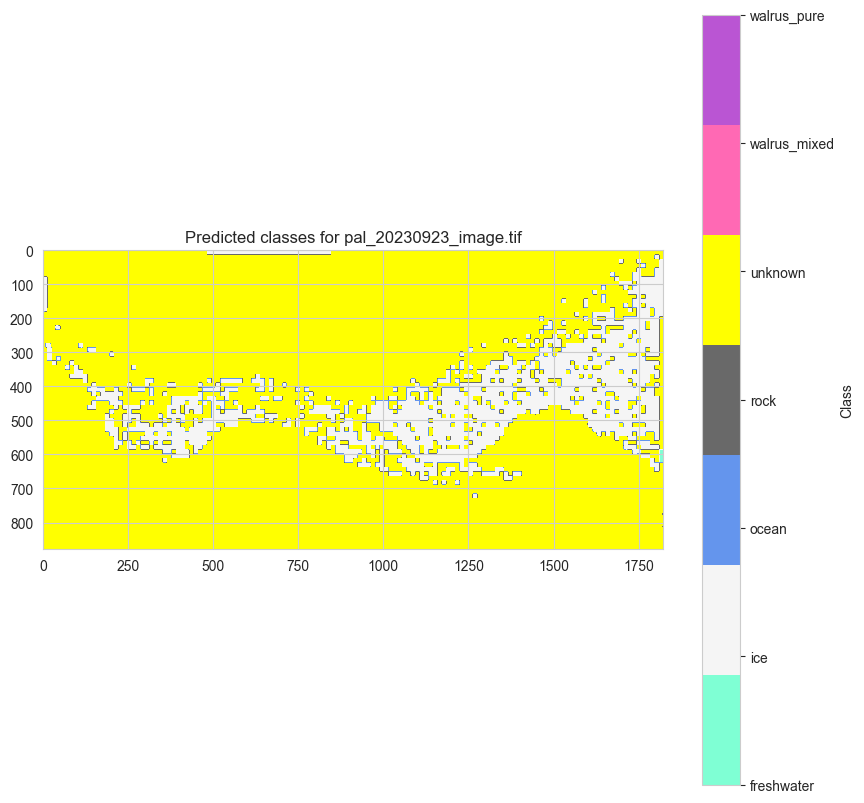

Labels present in sars_20230719_image.tif: ['ocean', 'unknown']


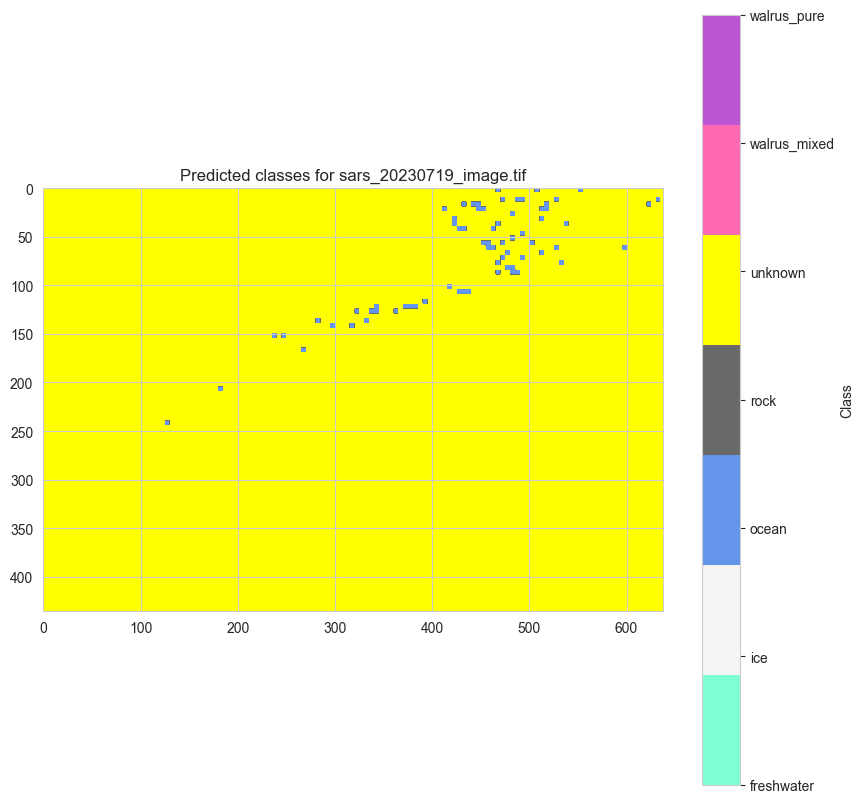

Labels present in sars_20230726_image.tif: ['ice', 'ocean', 'rock', 'unknown']


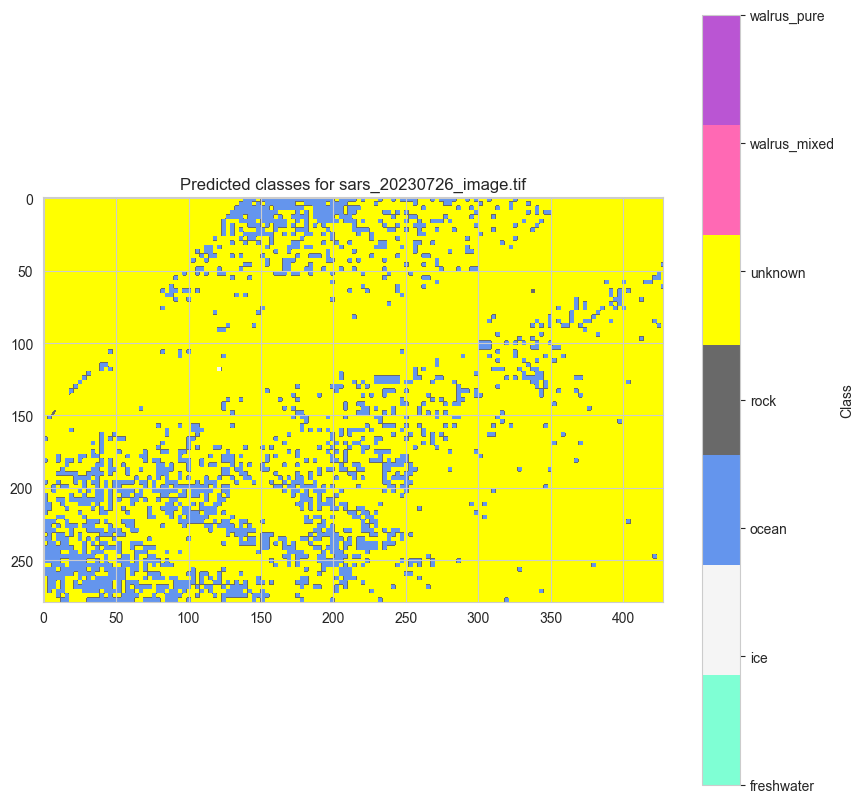

Labels present in sars_20230808_image.tif: ['ocean', 'unknown']


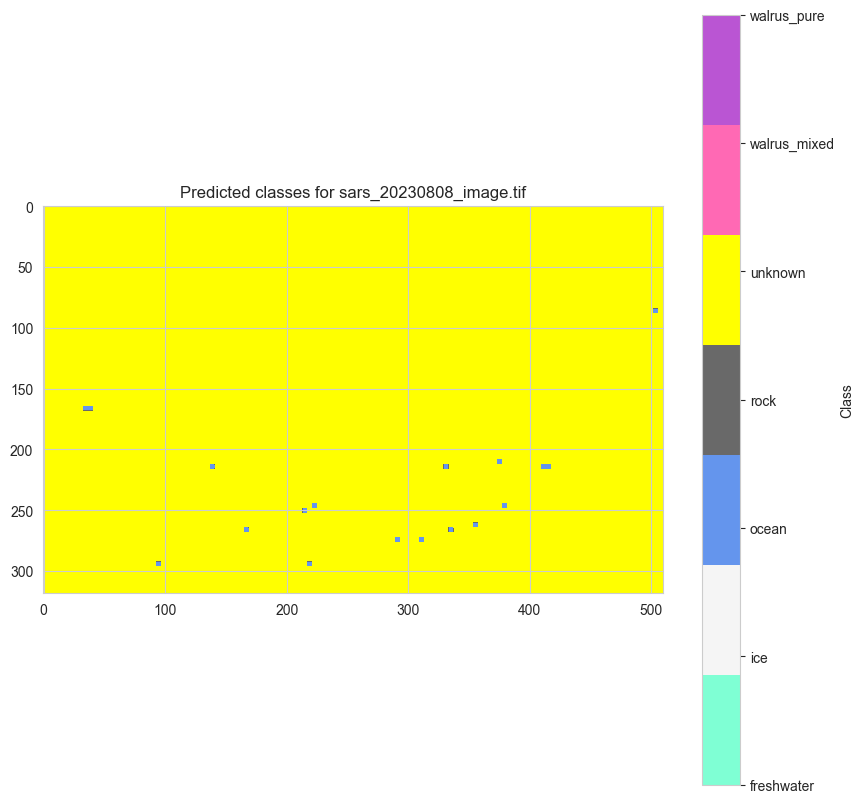

Labels present in tor_20230714_image.tif: ['ice', 'unknown']


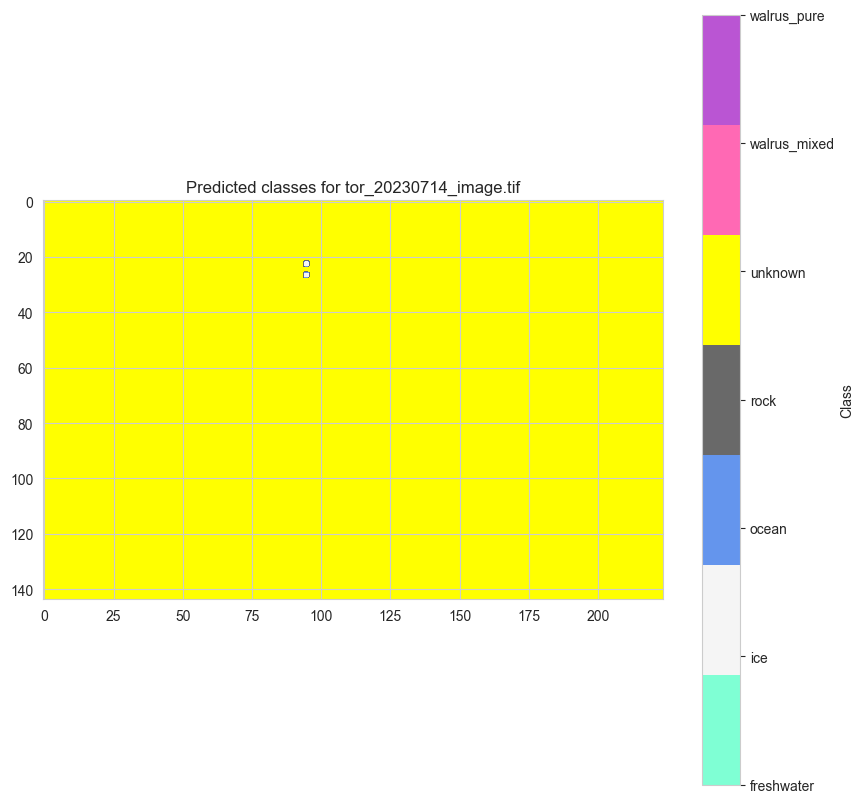

Labels present in tor_20230717_image.tif: ['ice', 'unknown']


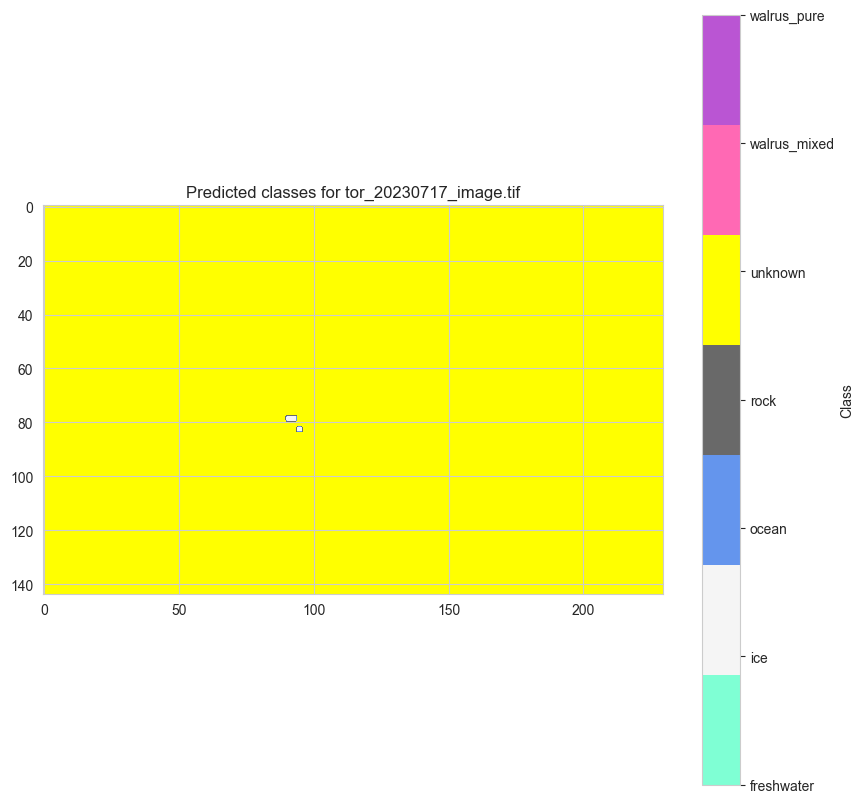

Labels present in tor_20230803_image.tif: ['ocean', 'unknown']


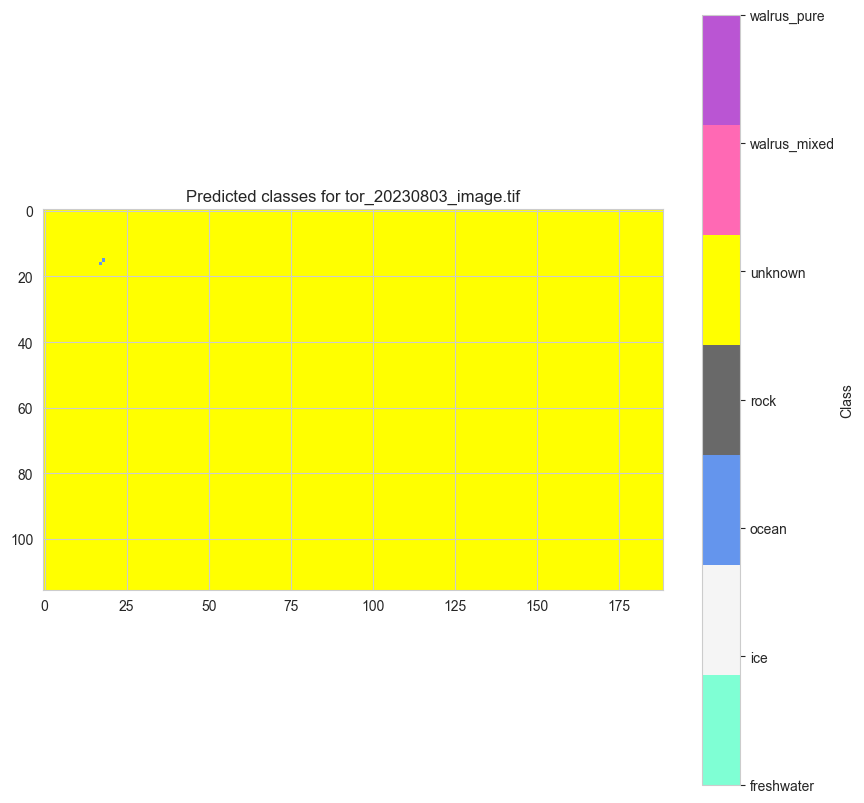

Labels present in tor_20230825_image.tif: ['ice', 'unknown']


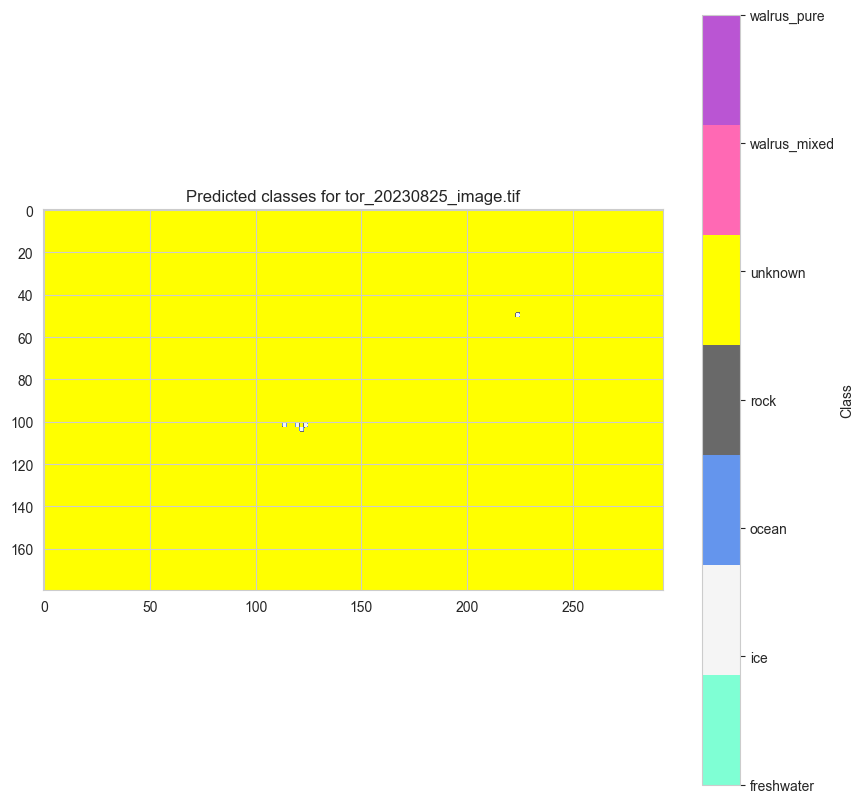

Labels present in tor_20230910_image.tif: ['ice', 'unknown']


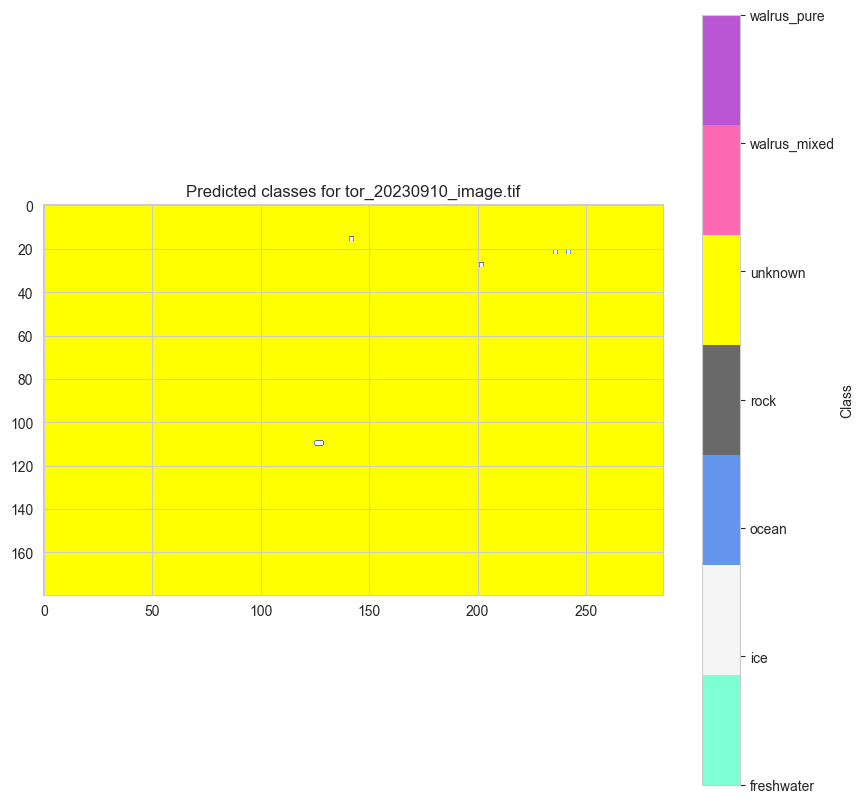

In [19]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read().transpose(1, 2, 0)
    
    segments = slic(image, n_segments=10000, compactness=1, sigma=1)
    
    object_features = []
    for region in regionprops(segments):
        object_pixels = image[region.coords[:, 0], region.coords[:, 1], :]
        object_features.append(np.concatenate([
            np.mean(object_pixels, axis=0),
            np.std(object_pixels, axis=0)
        ]))
    
    predictions = model.predict(object_features)
    
    predicted_image = np.zeros((image.shape[0], image.shape[1]), dtype=int)
    for region, prediction in zip(regionprops(segments), predictions):
        predicted_image[region.coords[:, 0], region.coords[:, 1]] = prediction
    
    return predicted_image

# Predict classes for unlabeled images
predicted_images = {}
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, rf)
    predicted_images[image_path] = predicted_image

# Define a color map for the labels
label_colors = {
    'freshwater': 'aquamarine',
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink',
    'unknown': 'yellow'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()